# Module 1 - Data Exploration
## Overview
In this module you will explore the driving observations captured from the simulator. In order to create the most effective model for __RoboStig__ to use, exploring and understanding the data is crucial. Therefore, after exploring the data, you will determine the best features to extract and train on. Additionally, you will look at various options to transform and augment the data to ensure:

1. You have a sufficient amount of data for training.
2. The data is formatted correctly and "cleaned" for training.
3. The training samples provide a enough variation to ensure that the eventual model does not overfit the training samples.

This process will leverage the following packages:
- The [zipfile](https://docs.python.org/3/library/zipfile.html) module provides tools to create, read, write, append, and list a ZIP file.
- The [os](https://docs.python.org/3/library/os.html) module provides a portable way to interact with the operating system.
- [urllib](https://docs.python.org/3/library/urllib.request.html#module-urllib.request) provides functions that help in opening URLs.
- The [sagemaker](https://github.com/aws/sagemaker-python-sdk) SDK is used for training and deploying machine learning models on Amazon SageMaker.
- [numpy](http://www.numpy.org/) is the main package for scientific computing with Python.
- The [pandas](https://pandas.pydata.org/index.html) analysis library is an easy-to-use data structures and data analysis tool.
- [seaborn](https://seaborn.pydata.org/) is a Python visualization library based on [matplotlib](https://matplotlib.org/).
- [sklearn](http://scikit-learn.org/stable/index.html) is tool for data mining and data analysis.

In [1]:
# Load the required libraries
import warnings
import zipfile
import os
import cv2
import urllib.request
import sagemaker
import numpy as np
import mxnet as mx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

## Load Training Obersavations
For the sake of brevity and conformity across the various modules, a [sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip) of driving observations is already provided for you to train the __RoboStig__ model. You are welcome to create your own training datasets by running the simulator in *Training Mode* and capturing your driving behavior.

<div class="alert alert-danger">
<strong>Please Note: </strong>Should you choose to use your own driving dataset, you will need to adjust the Jupyter Notebook code cells accordingly as the cells below have been adapted to the Sample dataset.
</div>

In [2]:
# Helper function
def download(url):
    """
    Helper function to download individual file from given url.
    
    Arguments:
    url -- full URL of the file to download
    
    Returns:
    filename -- downloaded file name
    """
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return filename

# To download and extract Sample Data
file = download('https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip')

# Extract the file
with zipfile.ZipFile(file) as zf:
    zf.extractall()

## View the Data
A full log of the driving observations is recorded in the `driving_log.csv` file. This file also includes the images captured from the *Left*, *Center* and *Right* camera angles from the vehicle. You will leverage this log, as well as the images, to train your model. But first, it's a good idea to view the contents of this file and derive some insights.

In the following code cells, we use the `pandas` library to create a tabular format (DataFrame) and display the first five rows of the `driving_log.csv` file.

In [3]:
# View the log data
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Describe the Data
Since the `.csv` file is now loaded as a `pandas` DataFrame, we can leverage the library to perform descriptive statistics, using the `describe()` method as the following code cell shows:

In [4]:
# Data Overview
print("Dataset Shape: {}\n".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


From the data, you will notice that there are $8036$ observations or driving "log" entries, which will be used to train your __RoboStig__ model. You can also see that there are $7$ features (or columns) to classify or categorize the observations.

By describing the summary statistics of the DataFrame, there are some interesting details that are further highlighted, namely:

1. Two thirds of the *steering* observations are $0.0$. This highlightes that the majority of the observations have a $0^o$ steering angle. In other words, the majority of the observations record the vehicle driving straight.
2. Two thirds of the *speed* observations clock the vehicle driving at around $30 Mph$. This coincides with the *max* speed value.
3. There is a correlation between the *speed* and *brake* observations since two thirds of the data shows that there is zero braking and and the average *speed* is around $28.1 Mph$.

## Visualize the Data
Another tactic to better understand the data, it to visualize some of the summary statistics. Once of the most common visualization techniques is to view the distribution or __shape__ of the data, such as a histogram. 

A well-known distribution of continuous values is the __bell curve__, as known as the __“normal”__ distribution or __"Gaussian"__ distribution. (Named after [Carl Friedrich Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss), first described it).

Since the object for __RoboStig__ is to steer the vehicle around the track, a good place to start visualizing the distrubtion of the *steering* angles. The following code cell shows the distribution of the data.

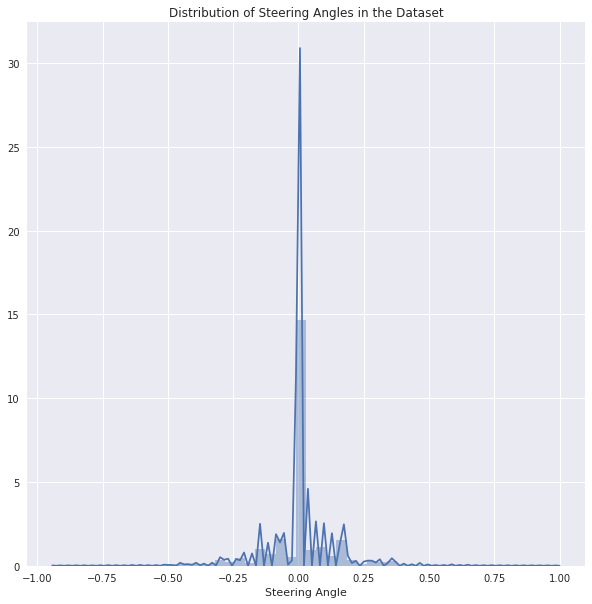

In [5]:
# Visualize the distribution of the data
# using the `seabourne` library
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

As you can visualize from the visualization above, the sample dataset is skewed toward the zero steering angle. In essence, any machine learning model trained from this data will only really know how to drive in a straight line. 

__Somehow you will need to get more training data that provides a better spread of steering angles!__

The next section will show you how to create more data from the existing dataset by preprocessing it.

---
# Data Preprocessing
One of the most important steps in any Machine Learning Pipeline is the *Data Preprocessing* step. This is where you ensure that you have the right data, that the data is correctly formatted and, most importantly, the data usable for training. The typical tasks that can take place during this step are:

- Removing or inferring missing data.
- Extracting the needed features from the data and removing unnecessary data..
- Inferring or creating more data.

In this next section, you will be implementing some of these tasks.

## Feature Extraction
As already mentioned, the *steering* angle is what __RoboStig__ will use to drive the car, thus it is the __outcome__ variable that your model is going to predict. The *independent* variables in this scenario, sometimes called the __experimental__ or __predictor__ variables are the *throttle*; *brake*; *speed* as well as all the images from the images for the *center*, *left* and *right* camera angles. 

So the first step in preprocessing the data is to separate the *outcome* and *predictor* variables from the dataset. Since the the variables are already loaded as `pandas dataframe`, the following cell shows how to separate the features into the specific category. The result will be the *predictor* features as `X` and the outcome as `y`.

In [6]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

## Image Transformations
Along with extracting the necessary features from the data, a similar pre-processing steps need to be applied to the images images themselves. This is necessary to align with the image formatting requirements of the NVIVIA model.

__Exercise:__ For your first exercise, you will need to implement the following image transformation functions:

1. __Crop images to only focus on the Region of Interest (ROI)__. The ROI in this case is simply the road. Therefore you will want to remove unnecessary parts of the image that are not relevant to the specific features that you want the model to focus on. So in this case, you will want to crop out the Sky as well as the hood of the vehicle.

<div class="alert alert-success">
<strong>Hint: </strong>The input images from the simulator are in RGB format and represented as a `numpy.array` of format (Height, Width, Channel. Extract just the parts of the height array and width array for the ROI.
</div>

2. __Resize images__. The NVIDIA model uses input images that are shaped as $66 \times 200 \times 3$, where the *height* $ = 66$ pixels, the *width* $= 200$ pixels and image *channels* $= 3$ (for *Red*, *Green* and *Blue*). 

<div class="alert alert-info">
<strong>Info: </strong>This function has already been implemented for you.
</div>

3. __Convert to YUV Channels__. The NVIDIA model is trained with the images converted from RGB to YUV color encoding. You will need to implement this transformation too.

<div class="alert alert-success">
<strong>Hint: </strong>The `cv2.cvtColor()` function from the OpenCV library may be helpful.
</div>

<div class="alert alert-danger">
<strong>Please Note: </strong>Every Code Cell has the solution that you can use if you get stuck. Simply click on the <strong>(Click to expand)</strong> link below each Code Cell.
</div>

In [7]:
# Image Transformation: Crop
def crop(image):
    """
    Crops the image by emoving the sky at the top and the car front at the bottom.

    Arguments:
    image -- numpy.array representing an RGB image of format (Height, Width, Channel).

    Returns:
    Cropped image.
    """
    image = image[60:-25, :, :]

    return image

<details><summary><b>Solution (Click to expand)</b></summary><p>

```
# Image Transformation: Crop
def crop(image):
    """
    Crops the image by emoving the sky at the top and the car front at the bottom.

    Arguments:
    image -- numpy.array representing an RGB image of format (Height, Width, Channel).
   
    Returns:
    Cropped image.
    """
    image = image[60:-25, :, :]

    return image
```

</p>
</details>

In [8]:
def resize(image):
    """
    Resize the image to the input shape for the NVIDIA model.

    Arguments:
    image -- numpy array representing image.
    height -- desired image height.
    width -- desired image width.

    Returns:
    Resized image.
    """
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

    return image

<details><summary><b>Solution (Click to expand)</b></summary><p>

```
# Image Transformation: Resize
def resize(image, height, width):
    """
    Resize the image to the input shape for the NVIDIA model.

    Arguments:
    image -- numpy array representing image.
    height -- desired image height.
    width -- desired image width.

    Returns:
    Resized image.
    """
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

    return image
```

</p>
</details>

In [9]:
# Image Transformation: Convert from RGB to YUV
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV color space.

    Arguments:
    image -- numpy array represnting the image.

    Returns:
    YUV image.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    return image

<details><summary><b>Solution (Click to expand)</b></summary><p>

```
# Image Transformation: Convert from RGB to YUV
def rgb2yuv(image):
    """
    Convert the image from RGB to YUV color space.

    Arguments:
    image -- numpy array represnting the image.

    Returns:
    YUV image.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    return image
```

</p>
</details>

## Image Augmentation
As already mentioned, you will need to add more diversity to the Training data, so the data isn;t skewed toward only driving straight. In order to accomplish this, you will take some of the existing images (primarily the __left__ and __right__ camera images) and adjust them just enough so that they can add the additional variance required.

<div class="alert alert-primary" role="alert">
<strong>Info: </stong>Many of the Python Machine Learning framework have built in methods to augment images. You can leverasge these if you wish, <strong>BUT</strong> make sure to adjust the steering angle data accordingly.
</div>

__Exercise:__ For the next exercise, you will implement *some* of the image augmentation techniques.

1. __Randomly flip the images.__ Here you will want to take $50%$ of all images and randomly flip them vertically. If the image is flipped, then the reverse of the steering angle must be applied.

<div class="alert alert-success" role="alert">
<strong>Hint: </strong>The `cv2.flip()` function may be helpful.
</div>

2. __Randomly shift the images.__ Here the image is shifted vertically and horizontally by a $0.002^O$ pixel shift. The steering angle is adjusted accordingly.

<div class="alert alert-info" role="alert">
<strong>Info: </strong>This function has already been implemented for you.
</div>

3. __Randomly distort the images.__ This augmentation technique applies a random distortion to the the images and also randomly adjusts the brightness of the images.

<div class="alert alert-info" role="alert">
<strong>Info: </strong>This function has already been implemented for you.
</div>

4. __Randomly adjust the brightness of the images.__ Here you will implement a function adjust the brightness, either making the image brighter or lowering the brightness (making the image darker).

<div class="alert alert-success" role="alert">
<strong>Hint: </strong>The `cv2.cvtColor()` function may be helpful, paying attention to HSV (Hue, Saturation, Value) or HSB.
</div>

In [10]:
# Image Augmentation: Random Flip
def random_flip(image, steering_angle):
    """
    Randomly flip the 50% of the images from left to right and vice-versa.
    Additionally, adjust the steering angle accordingly.

    Arguments:
    image -- pre-processed input image.
    steering_amngle -- pre-processed steering angle.

    Returns:
    image -- flipped image.
    steering_angle -- adjusted steering angle.
    """
    # Randomly select 0.5 of the images
    if np.random.rand() < 0.5:
        # Apply the flip function to the vertical axis.
        image = cv2.flip(image, 1)

        # Adjust the steering angle to the reverse of the current steering angle.
        steering_angle = -steering_angle

    # Return the "flipped" image and new steering angle.

    return image, steering_angle

<details><summary><b>Solution (Click to expand)</b></summary><p>

```
# Image Augmentation: Random Flip
def random_flip(image, steering_angle):
    """
    Randomly flip the 50% of the images from left to right and vice-versa.
    Additionally, adjust the steering angle accordingly.

    Arguments:
    image -- pre-processed input image.
    steering_amngle -- pre-processed steering angle.

    Returns:
    image -- flipped image.
    steering_angle -- adjusted steering angle.
    """
    # Randomly select 0.5 of the images
    if np.random.rand() < 0.5:
        # Apply the flip function to the vertical axis.
        image = cv2.flip(image, 1)

        # Adjust the steering angle to the reverse of the current steering angle.
        steering_angle = -steering_angle

    # Return the "flipped" image and new steering angle.

    return image, steering_angle
```

</p>
</details>

In [11]:
# Image Augmentation: Random Translate
def translate(image, steering_angle, x_range, y_range):
    """
    Randomly shift (translate) the image vertically and horizontally.

    Arguments:
    image -- pre-processed input image.
    steering_angle -- pre-processed steering angle.
    x_range -- x-axis pixels.
    y_range -- y-axis pixels.

    Returns:
    image -- translated image.
    steering_angle -- adjusted steeing angle.
    """
    # Randomly adjust the x and y axis
    x_transform = x_range * (np.random.rand() - 0.5)
    y_transform = y_range * (np.random.rand() - 0.5)

    # Adjust the steering angle
    steering_angle += x_transform * 0.002
    m_transform = np.float32([[1, 0, x_transform], [0, 1, y_transform]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, m_transform, (width, height))

    return image, steering_angle

# Image Augmentation: Random Distortion
def distort(image):
    """
    Add distortion to random images and adjust the brightness.

    Arguments:
    image -- pre-processed input image.

    Returns:
    new_image -- distorted image.
    """
    # Create placeholder numpy array for the new image
    new_img = image.astype(float)

    # Add random brightness
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:, :, 0] + value) > 255
    if value <= 0:
        mask = (new_img[:, :, 0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)

    # Add random shadow 
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0, w)
    factor = np.random.uniform(0.6, 0.8)
    if np.random.rand() > .5:
        new_img[:, 0:mid, 0] *= factor
    else:
        new_img[:, mid:w, 0] *= factor
    
    # Randomly shift the horizon
    h, w, _ = new_img.shape
    horizon = 2 * h / 5
    v_shift = np.random.randint(-h / 8, h / 8)
    pts1 = np.float32([[0, horizon], [w, horizon], [0, h], [w, h]])
    pts2 = np.float32([[0, horizon + v_shift], [w, horizon + v_shift], [0, h], [w, h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

    return new_img.astype(np.uint8)

# Image Augmentation: Random Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # Convert image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Randomly adjust the brightness ratio and apply it
    # to the image
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio

    # Convert back to RGB and return the image
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

<details><summary><b>Solution (Click to expand)</b></summary><p>

```
# Image Augmentation: Random Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # Convert image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Randomly adjust the brightness ratio and apply it
    # to the image
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio

    # Convert back to RGB and return the image
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
```

</p>
</details>

## Image Augmentation Example

```text
|--data
|  |--driving_log.csv
|  |--IMG
|  |  |--center_2016_12_01_13_30_48_287.jpg
|  |  |--left_2016_12_01_13_30_48_287.jpg
|  |  ...
```

In [12]:
# Helper function
def load(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def transform(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

### Random Sample Image

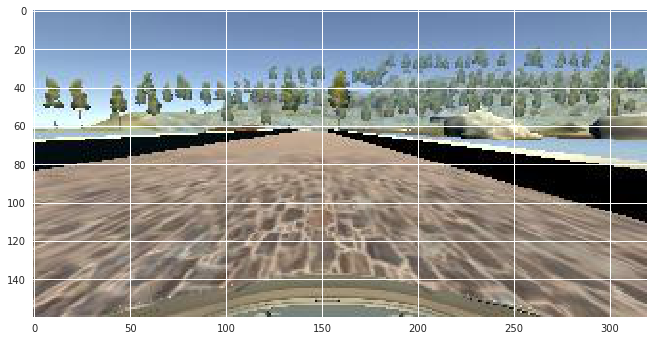

In [13]:
# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][0]
img = load('data', random_image)
#img = ('', random_image)
plt.rcParams['figure.figsize'] = (11.0, 10.0)
plt.imshow(img);

### Plot Augmented Images

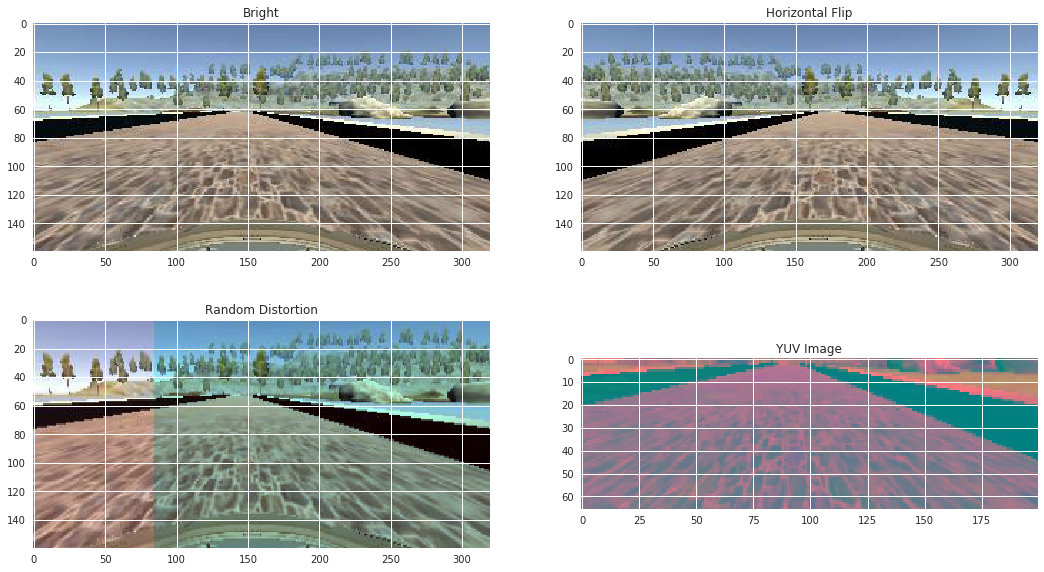

In [14]:
# Create Subpluts for Augmented Images
plt.close('all')
fig = plt.figure(figsize=(18., 10.))
sub1 = fig.add_subplot(221)
sub1.set_title('Bright')
sub1.imshow(brightness(img))
sub2 = fig.add_subplot(222)
sub2.set_title('Horizontal Flip')
sub2.imshow(cv2.flip(img, 1))
sub3 = fig.add_subplot(223)
sub3.set_title('Random Distortion')
sub3.imshow(distort(img));
sub4 = fig.add_subplot(224)
sub4.set_title('YUV Image')
sub4.imshow(transform(img));
plt.show()

## Image Augmentation Pipeline...
__BLah Blah Blah__

In [15]:
# Batch Image Configurations
HEIGHT, WIDTH, CHANNELS = 66, 200, 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Aumentation Pipeline Functions
def choose(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load(data_dir, right), steering_angle - 0.2
    return load(data_dir, center), steering_angle

def augment(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = translate(image, steering_angle, range_x, range_y)
    image = brightness(image)
    image = distort(image)
    return image, steering_angle


def aug_pipeline(data_dir, image_paths, steering_angles, size, is_training):
    """
    #Generate training image give image paths and associated steering angles
    """
    images = np.empty([size, HEIGHT, WIDTH, CHANNELS])
    steering = np.empty(size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 1.:
                image, steering_angle = augment(data_dir, center, left, right, steering_angle)
            else:
                image = load(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = transform(image)
            steering[i] = steering_angle
            i += 1
            if i == size:
                break
        return np.array(images).astype(np.float32), np.array(steering).astype(np.float32)


Use the Augmentation Pipeline functions to create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [16]:
X_sample, y_sample = aug_pipeline('data', X, y, len(X),True)

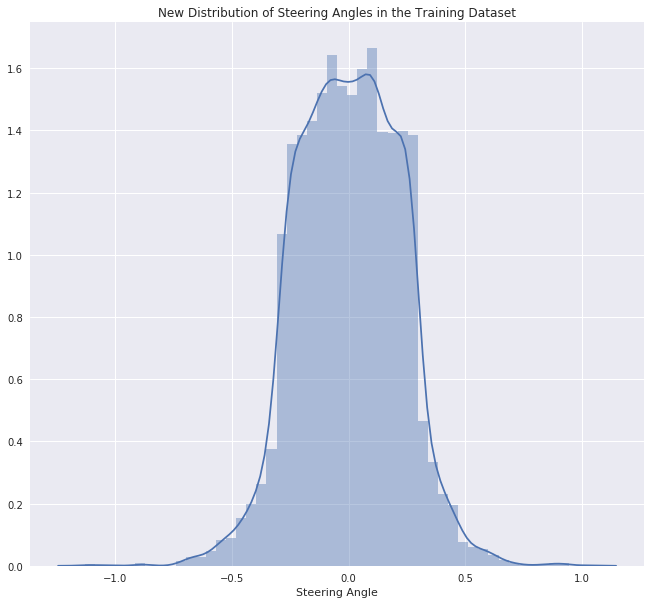

In [17]:
# Plot New Distribution of training examples
fig = sns.distplot(y_sample)
plt.xlabel("Steering Angle")
plt.title("New Distribution of Steering Angles in the Training Dataset")
plt.show(fig);

As can be seen from the sample datatset, the disribution of steering angles is more uniform. Next we create the datasets for the model and upload them to S3.

---
# Prepare the Training/Validation Datsets
Using a 90/10 split, the dataset is separated to 90% for Training and 10% for Validation. The final test onm the datset will be handled by the simulator.

In [18]:
# Libraries and SageMaker configuration
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# Create Training and Validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

__blah blah blah__

In [19]:
# Preprocess through the pipline
X_train, y_train = aug_pipeline('data', X_train, y_train, len(X_train), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

__blah blah blah__  

<details><summary>NOTE TO SELF</summary>
<p>
Need to double check if reshaping is necessary as `model.py` includes a `tranform()` function.  
</p>
<p>
```
# Reshape images as a 4D Tensor
X_train = X_train.reshape(-1, 3, 66, 200)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 3, 66, 200)
y_valid = y_valid.reshape(-1, 1)
```
</p>
</details>

In [20]:
# View resultant shape
print("Training Dataset Shape: {}\n".format(X_train.shape))
print("Validation Dataset Shape: {}".format(X_valid.shape))

Training Dataset Shape: (7232, 66, 200, 3)

Validation Dataset Shape: (804, 66, 200, 3)


__blah blah blah__

In [21]:
# Create local repository for Numpy Arrays
if not os.path.exists('/tmp/data'):
    os.mkdir('/tmp/data')

# Save the Dataset as Numpy Arrays
np.save('/tmp/data/train_X.npy', X_train)
np.save('/tmp/data/train_Y.npy', y_train)
np.save('/tmp/data/valid_X.npy', X_valid)
np.save('/tmp/data/valid_Y.npy', y_valid)

---
# Next Step: Build and Train the model in SageMaker
[Module 2](../2_SageMakerBYOM/README.md)